In [157]:
import os 
import numpy as np 
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt

import seaborn as sns

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller

from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import pmdarima as pm
from pmdarima.model_selection import train_test_split

from fbprophet import Prophet

from pandas import to_datetime

import itertools
import warnings

import datetime
from datetime import datetime

## Importin S&P500 Data

In [67]:
df = pd.read_csv('SP500.csv')

In [68]:
df.head()

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,"Jun 07, 2021","4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,"Jun 04, 2021","4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,"Jun 03, 2021","4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,"Jun 02, 2021","4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,"Jun 01, 2021","4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"


In [69]:
df.describe()

,Date,Open,High,Low,Close*,Adj Close**,Volume
count,1258,1258,1258,1258,1258,1258,1258
unique,1258,1248,1252,1251,1252,1252,1257
top,"Feb 13, 2020","2,465.38","2,578.29","2,160.39","2,723.06","2,723.06","3,884,480,000"
freq,1,2,2,2,2,2,2


In [70]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         1258 non-null   object
 1   Open         1258 non-null   object
 2   High         1258 non-null   object
 3   Low          1258 non-null   object
 4   Close*       1258 non-null   object
 5   Adj Close**  1258 non-null   object
 6   Volume       1258 non-null   object
dtypes: object(7)
memory usage: 68.9+ KB


In [71]:
df.isnull().sum()


# no null values present

Date           0
Open           0
High           0
Low            0
Close*         0
Adj Close**    0
Volume         0
dtype: int64

## Data Preparation

Renaming Close and Adj Close columns


In [72]:
df = df.rename(columns={"Close*":"close","Adj Close**":"adj_close"})

Converting date column to date values.

In [73]:
df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%b %d, %Y'))

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2021-06-07,"4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,2021-06-04,"4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,2021-06-03,"4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,2021-06-02,"4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,2021-06-01,"4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"
...,...,...,...,...,...,...,...
1253,2016-06-14,"2,076.65","2,081.30","2,064.10","2,075.32","2,075.32","3,759,770,000"
1254,2016-06-13,"2,091.75","2,098.12","2,078.46","2,079.06","2,079.06","3,392,030,000"
1255,2016-06-10,"2,109.57","2,109.57","2,089.96","2,096.07","2,096.07","3,515,010,000"
1256,2016-06-09,"2,115.65","2,117.64","2,107.73","2,115.48","2,115.48","3,290,320,000"


Converting the other columns to float

In [74]:
    df.iloc[:]

,Date,Open,High,Low,close,adj_close,Volume
0,2021-06-07,"4,229.34","4,232.34","4,215.66","4,226.52","4,226.52","3,835,570,000"
1,2021-06-04,"4,206.05","4,233.45","4,206.05","4,229.89","4,229.89","3,487,070,000"
2,2021-06-03,"4,191.43","4,204.39","4,167.93","4,192.85","4,192.85","4,579,450,000"
3,2021-06-02,"4,206.82","4,217.37","4,198.27","4,208.12","4,208.12","4,860,930,000"
4,2021-06-01,"4,216.52","4,234.12","4,197.59","4,202.04","4,202.04","4,122,960,000"
...,...,...,...,...,...,...,...
1253,2016-06-14,"2,076.65","2,081.30","2,064.10","2,075.32","2,075.32","3,759,770,000"
1254,2016-06-13,"2,091.75","2,098.12","2,078.46","2,079.06","2,079.06","3,392,030,000"
1255,2016-06-10,"2,109.57","2,109.57","2,089.96","2,096.07","2,096.07","3,515,010,000"
1256,2016-06-09,"2,115.65","2,117.64","2,107.73","2,115.48","2,115.48","3,290,320,000"


In [75]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
'en_US.UTF-8'

'en_US.UTF-8'

In [76]:
for i in range(1,7):
    df.iloc[:,i]=df.iloc[:,i].apply(lambda x: float(x.replace(',','')))

In [77]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1258 non-null   datetime64[ns]
 1   Open       1258 non-null   float64       
 2   High       1258 non-null   float64       
 3   Low        1258 non-null   float64       
 4   close      1258 non-null   float64       
 5   adj_close  1258 non-null   float64       
 6   Volume     1258 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 68.9 KB


## Visualising Time Series Data

In [78]:
sns.set(rc={'figure.figsize':(14,6)})

Date
Open


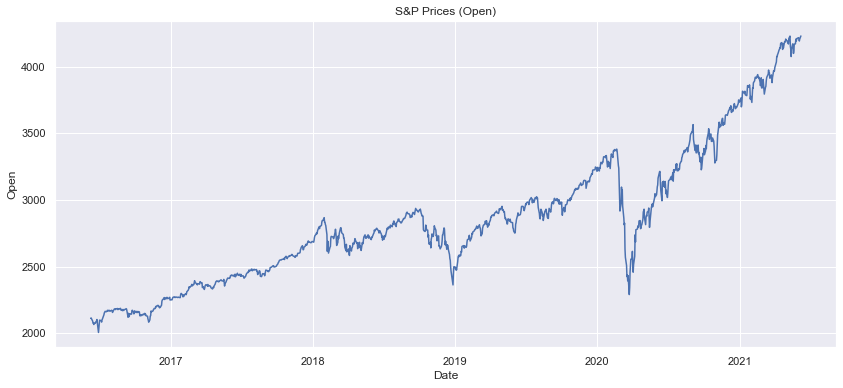

High


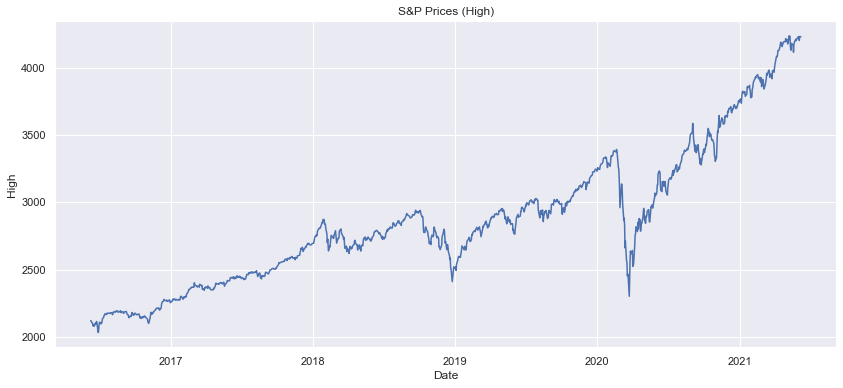

Low


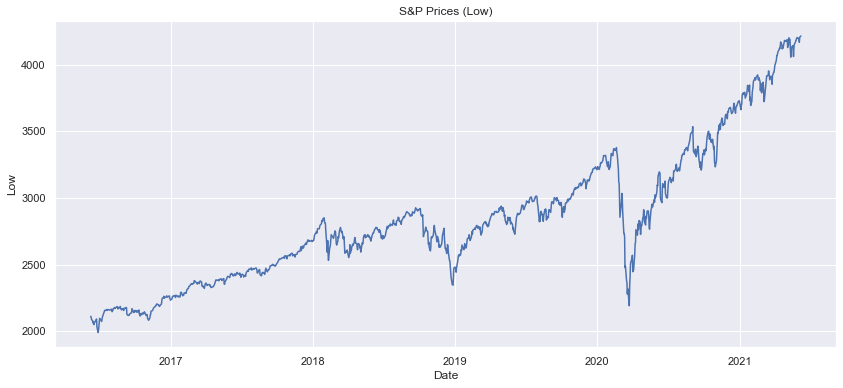

close


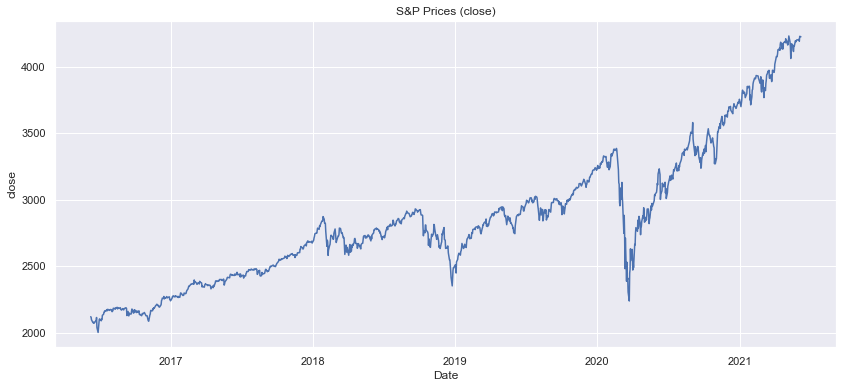

adj_close


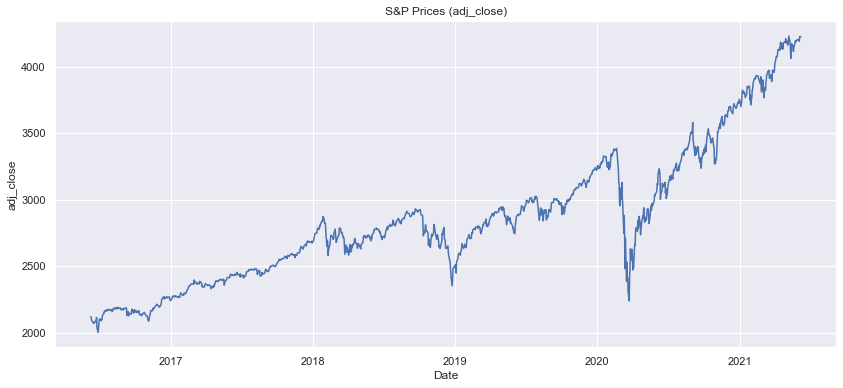

Volume


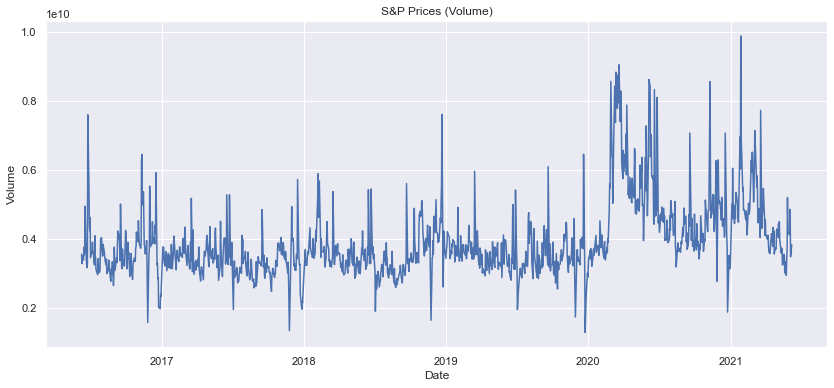

In [79]:
sns.set_theme(style="darkgrid")
for column in list(df.columns):
    print(column)
    if column != "Date":
        sns.lineplot(x="Date", y=column, data=df).set_title("S&P Prices (" + column + ")")
        plt.show()
        

In [80]:
df['Date_index'] = df['Date']
df = df.iloc[::-1].set_index('Date_index')

In [81]:
df

,Date,Open,High,Low,close,adj_close,Volume
Date_index,,,,,,,
2016-06-08,2016-06-08,2112.71,2120.55,2112.71,2119.12,2119.12,3.562060e+09
2016-06-09,2016-06-09,2115.65,2117.64,2107.73,2115.48,2115.48,3.290320e+09
2016-06-10,2016-06-10,2109.57,2109.57,2089.96,2096.07,2096.07,3.515010e+09
2016-06-13,2016-06-13,2091.75,2098.12,2078.46,2079.06,2079.06,3.392030e+09
2016-06-14,2016-06-14,2076.65,2081.30,2064.10,2075.32,2075.32,3.759770e+09
...,...,...,...,...,...,...,...
2021-06-01,2021-06-01,4216.52,4234.12,4197.59,4202.04,4202.04,4.122960e+09
2021-06-02,2021-06-02,4206.82,4217.37,4198.27,4208.12,4208.12,4.860930e+09
2021-06-03,2021-06-03,4191.43,4204.39,4167.93,4192.85,4192.85,4.579450e+09


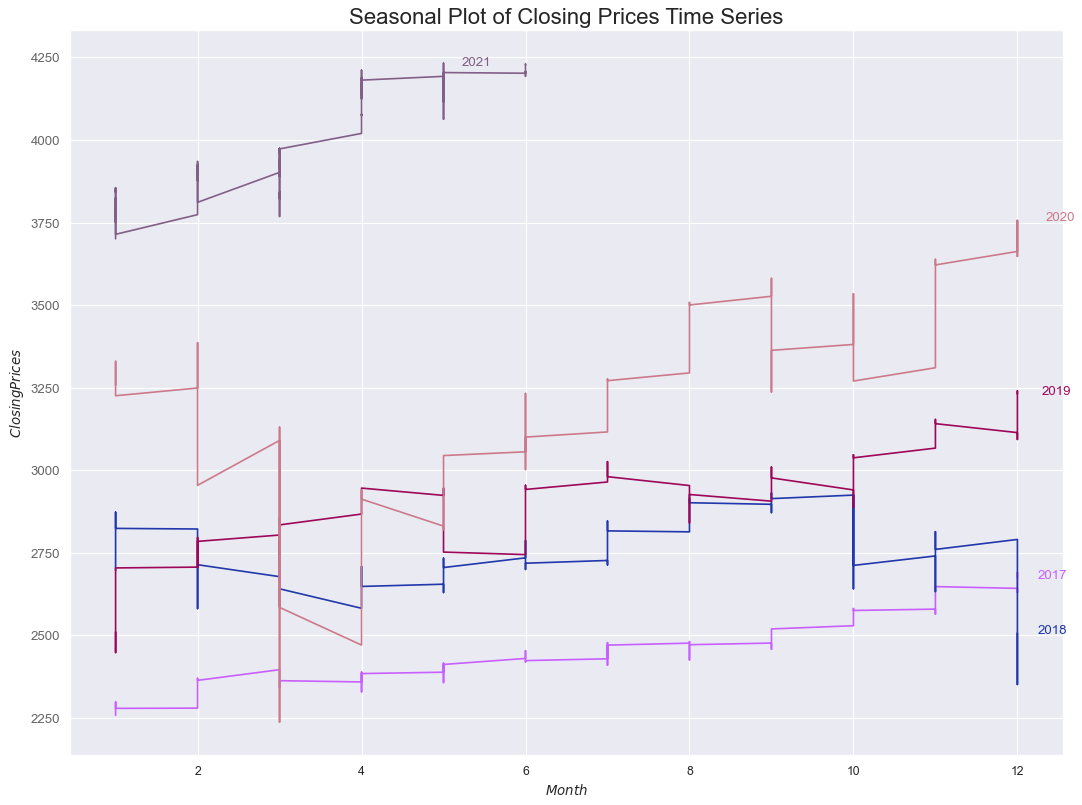

In [82]:
# Seasonal Plot

df['year'] = [d.year for d in df.Date]
df['month'] = [d.month for d in df.Date]
years = df['year'].unique()

np.random.seed(100)
mycolors = np.random.choice(list(mpl.colors.XKCD_COLORS.keys()), len(years), replace=False)


plt.figure(figsize=(16,12), dpi= 80)
for i, y in enumerate(years):
    if i > 0:                
        plt.plot('month', 'close', data=df.loc[df.year==y, :], color=mycolors[i])
        plt.text(df.loc[df.year==y, :].shape[0]/20.5, df.loc[df.year==y, 'close'][-1:].values[0], y, fontsize=12, color=mycolors[i])

plt.gca().set(ylabel='$Closing Prices$', xlabel='$Month$')
plt.yticks(fontsize=12, alpha=.7)
plt.title("Seasonal Plot of Closing Prices Time Series", fontsize=20)
plt.show()

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

In [83]:
df.corr()

,Open,High,Low,close,adj_close,Volume,year,month
Open,1.000000,0.999512,0.999170,0.998813,0.998813,0.261795,0.902112,-0.107580
High,0.999512,1.000000,0.998768,0.999267,0.999267,0.273622,0.907404,-0.110930
Low,0.999170,0.998768,1.000000,0.999354,0.999354,0.241261,0.895624,-0.104525
close,0.998813,0.999267,0.999354,1.000000,1.000000,0.255953,0.901986,-0.108644
adj_close,0.998813,0.999267,0.999354,1.000000,1.000000,0.255953,0.901986,-0.108644
Volume,0.261795,0.273622,0.241261,0.255953,0.255953,1.000000,0.435259,-0.182921
year,0.902112,0.907404,0.895624,0.901986,0.901986,0.435259,1.000000,-0.280155
month,-0.107580,-0.110930,-0.104525,-0.108644,-0.108644,-0.182921,-0.280155,1.000000


## Choosing Target Variables

We will conduct the timeseries analysis on the adjusted closing price.

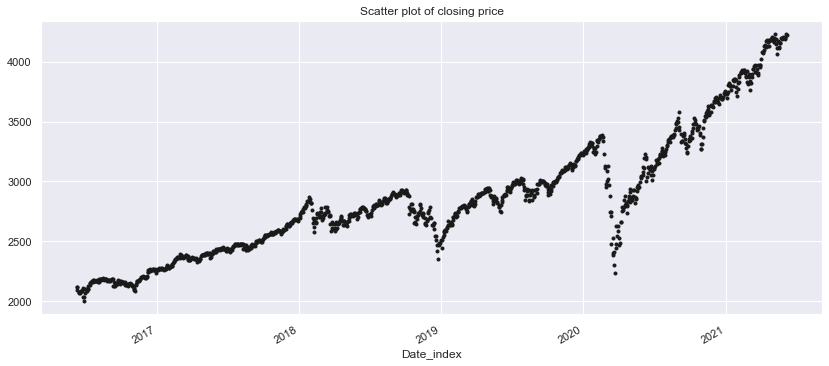

In [84]:
df_close = df['adj_close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

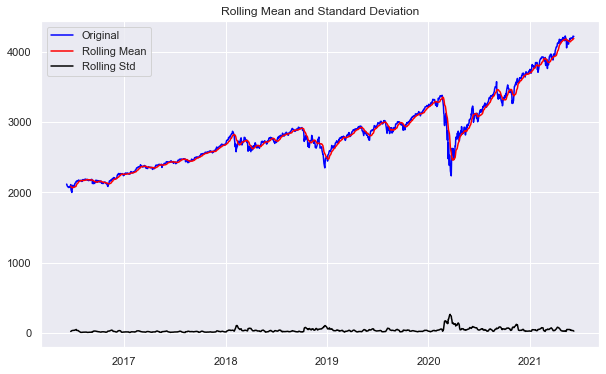

Results of dickey fuller test
Test Statistics                  -0.114882
p-value                           0.947936
No. of lags used                  9.000000
Number of observations used    1248.000000
critical value (1%)              -3.435601
critical value (5%)              -2.863859
critical value (10%)             -2.568004
dtype: float64


In [98]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Data is non-stationary. Hence, we now decompose the time series data into the 4 components - observed, trend, seasonal and residual.

<ipython-input-109-344673498274>:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df_close, model='multiplicative', freq = 30)


<Figure size 720x432 with 0 Axes>

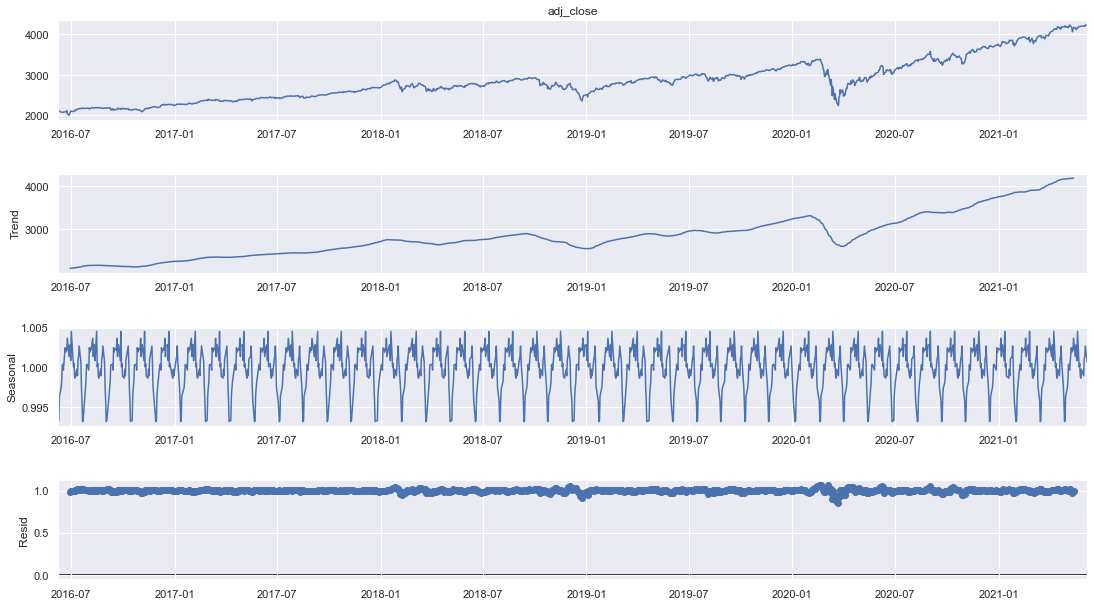

In [109]:
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
residual = result.resid
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

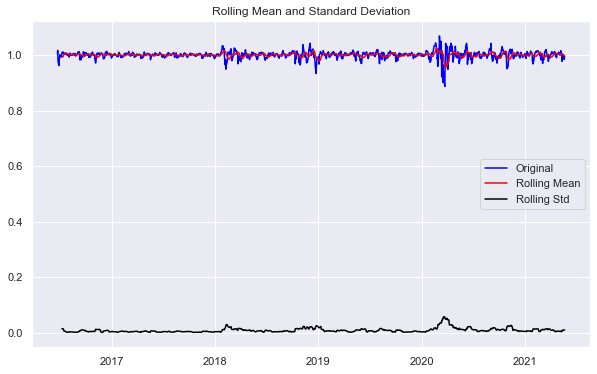

Results of dickey fuller test
Test Statistics               -1.072160e+01
p-value                        3.140534e-19
No. of lags used               2.100000e+01
Number of observations used    1.216000e+03
critical value (1%)           -3.435739e+00
critical value (5%)           -2.863920e+00
critical value (10%)          -2.568037e+00
dtype: float64


In [106]:
residual.dropna(inplace=True)
test_stationarity(residual)

No handles with labels found to put in legend.


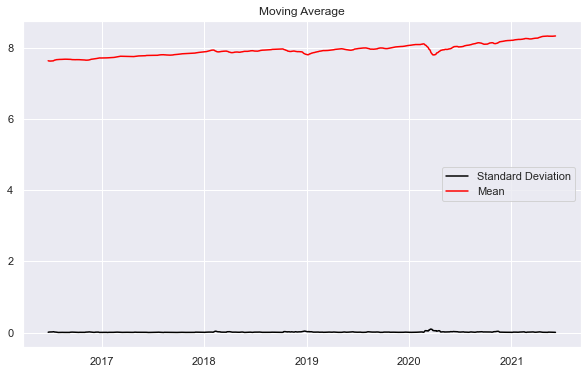

In [110]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## Splitting the Raw Data

In [132]:
df_log

Date_index
2016-06-08    7.658756
2016-06-09    7.657037
2016-06-10    7.647819
2016-06-13    7.639671
2016-06-14    7.637871
                ...   
2021-06-01    8.343325
2021-06-02    8.344771
2021-06-03    8.341136
2021-06-04    8.349931
2021-06-07    8.349134
Name: adj_close, Length: 1258, dtype: float64

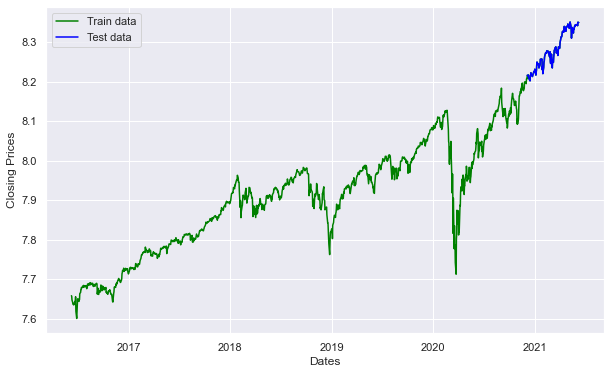

In [124]:
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]

train_data = df_log[df_log['Date']]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

##  Running Auto Arima

In [130]:
train_data

Date_index
2016-06-13    7.639671
2016-06-14    7.637871
2016-06-15    7.636028
2016-06-16    7.639156
2016-06-17    7.635893
                ...   
2020-11-27    8.199286
2020-11-30    8.194679
2020-12-01    8.205888
2020-12-02    8.207677
2020-12-03    8.207053
Name: adj_close, Length: 1129, dtype: float64

In [149]:
model_autoARIMA = auto_arima(
    train_data,
    trace=True,
    suppress_warnings=True
)

print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-6773.302, Time=0.68 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-6682.893, Time=0.11 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-6753.206, Time=0.26 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-6735.840, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-6683.064, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-6771.424, Time=0.18 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-6764.185, Time=0.39 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-6844.008, Time=1.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-6769.266, Time=0.21 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-6785.958, Time=1.68 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-6769.577, Time=1.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-6773.648, Time=1.35 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=-6781.046, Time=1.02 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-6776.083, Time=1.64 sec
 ARIMA(3,1,2)(0,0,0

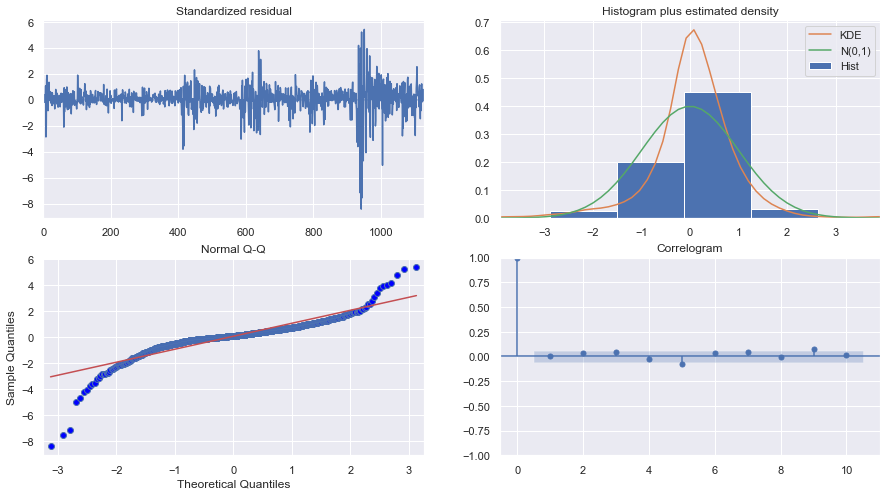

In [150]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [151]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

C:\Users\edmun\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
C:\Users\edmun\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency

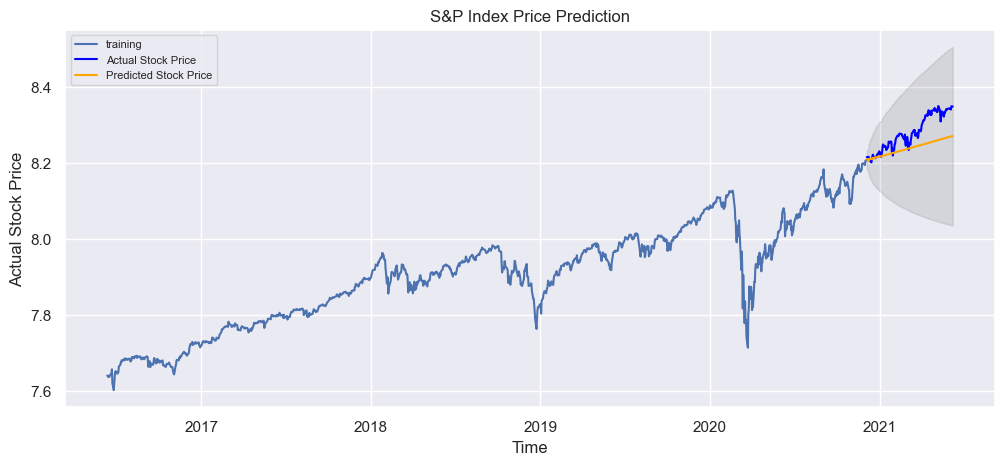

In [156]:
# Forecast
fc, se, conf = fitted.forecast(126, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('S&P Index Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [158]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.002441868035994697
MAE: 0.040820389415772804
RMSE: 0.04941526116489416
MAPE: 0.004912035696507179


## Running Prophet

## Combining the Time Series Models

## Exporting Dataa to CSV